In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

In [ ]:
df = pd.read_csv("../data/spam.csv", encoding="latin-1")
df = df.iloc[:, :2]
df.columns = ["label", "message"]

df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
df["label"].value_counts()

label
ham     4825
spam     747
Name: count, dtype: int64

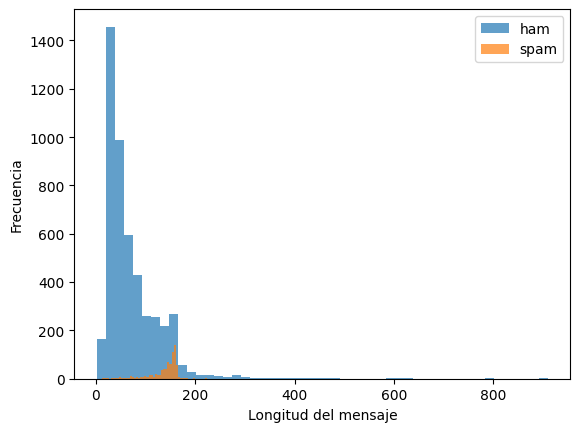

In [6]:
# EDA Simple
df["length"] = df["message"].str.len()

plt.hist(df[df["label"]=="ham"]["length"], bins=50, alpha=0.7, label="ham")
plt.hist(df[df["label"]=="spam"]["length"], bins=50, alpha=0.7, label="spam")
plt.legend()
plt.xlabel("Longitud del mensaje")
plt.ylabel("Frecuencia")
plt.show()

In [7]:
#Procesamiento de texto
import re
import string

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\d+", "", text)
    return text.strip()

df["clean"] = df["message"].apply(clean_text)
df[["message", "clean"]].head()


,message,clean
0,"Go until jurong point, crazy.. Available only ...",go until jurong point crazy available only in ...
1,Ok lar... Joking wif u oni...,ok lar joking wif u oni
2,Free entry in 2 a wkly comp to win FA Cup fina...,free entry in a wkly comp to win fa cup final...
3,U dun say so early hor... U c already then say...,u dun say so early hor u c already then say
4,"Nah I don't think he goes to usf, he lives aro...",nah i dont think he goes to usf he lives aroun...


In [8]:
#Entrenamiento y evaluación del modelo
X = df["clean"]
y = df["label"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [9]:
#Modelado 
from sklearn.pipeline import Pipeline

model = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1, 2),
        stop_words="english",
        min_df=3,
        max_df=0.9
    )),
    ("clf", MultinomialNB())
])

model.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2),
                                 stop_words='english')),
                ('clf', MultinomialNB())])

In [10]:
#Evaluación del modelo
y_pred = model.predict(X_test)

print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nReporte:\n", classification_report(y_test, y_pred))
print("\nMatriz de confusión:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.9695

Reporte:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       0.99      0.78      0.87       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115


Matriz de confusión:
 [[965   1]
 [ 33 116]]


In [11]:
joblib.dump(model, "modelo_spam.joblib")


['modelo_spam.joblib']

In [ ]:
#Pruebas con ejemplos nuevos
ejemplos = [
    "WIN a FREE prize now!!!",
    "Hola, ¿llegás a las 7 a casa?",
    "You have won 1000$ cash, click here to claim",
    "El codigo de seguridad es 12345, no lo compartas con nadie.",
    "El codigo de seguimiento de tu paquete es 987654321."
]

for txt in ejemplos:
    pred = model.predict([txt])[0]
    print(f"'{txt}'  -->  {pred}")


'WIN a FREE prize now!!!'  -->  spam
'Hola, ¿llegás a las 7 a casa?'  -->  ham
'You have won 1000$ cash, click here to claim'  -->  spam
'El codigo de seguridad es 12345, no lo compartas con nadie.'  -->  ham
'El codigo de seguimiento de tu paquete es 987654321.'  -->  ham


In [16]:
# Interfaz de línea de comandos para clasificar mensajes
import joblib

def main():
    model = joblib.load("modelo_spam.joblib")
    print("Modelo cargado. Escribí mensajes para clasificar (ENTER vacío para salir).\n")

    while True:
        txt = input("> ")
        if not txt.strip():
            break
        pred = model.predict([txt])[0]
        proba = model.predict_proba([txt])[0]
        print(f"Predicción: {pred}")
        print(f"Probabilidades (ham, spam): {proba}\n")

if __name__ == "__main__":
    main()


Modelo cargado. Escribí mensajes para clasificar (ENTER vacío para salir).

Predicción: ham
Probabilidades (ham, spam): [0.86582903 0.13417097]

Predicción: ham
Probabilidades (ham, spam): [0.86582903 0.13417097]

